# Choosing between shared and group-specifi expressions, given two groups' observed interactions

January 2025

In [1]:
# import jax
import jax.numpy as jnp
# from jax import lax
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2

import math

import data_tools
import model_tools
import utils

from enums import *

sns.set_theme('talk')

In [2]:
data = data_tools.get_data(expt_type=ExptTypes.SharedUnique)
tangram_info = data_tools.get_tangram_info(expt_type=ExptTypes.SharedUnique)
data_organized = data_tools.make_data_matrices(data, expt_type=ExptTypes.SharedUnique)


In [3]:
tangram_info

,tangram_set,counterbalance,audience_group,shared.tangram,unique.tangram
0,0,a,Blue,B,A
1,0,a,Blue,B,D
2,0,a,Blue,B,H
3,0,a,Blue,C,A
4,0,a,Blue,C,D
...,...,...,...,...,...
103,2,b,Red,G,E
104,2,b,Red,G,K
105,2,b,Red,I,C
106,2,b,Red,I,E


In [4]:
alphas = jnp.array([1]) 
w_rs = jnp.arange(0, 20, 0.1)
w_ss = jnp.arange(0, 10, 0.1)
w_cs = jnp.array([0]) # no cost in design

In [5]:
params_list_no_social = utils.get_params_list(
    alphas=alphas, w_rs=w_rs, w_ss=jnp.array([0]), w_cs=w_cs
)

params_list_social = utils.get_params_list(
    alphas=alphas, w_rs=w_rs, w_ss=w_ss, w_cs=w_cs
)

In [6]:
best_params_no_social, best_nll_no_social, _ = model_tools.fit_params_overall(data_organized, tangram_info, params_list=params_list_no_social, expt_type=ExptTypes.SharedUnique)
best_params_social, best_nll_social, _ = model_tools.fit_params_overall(data_organized, tangram_info, params_list=params_list_social, expt_type=ExptTypes.SharedUnique)

In [7]:
print(f"Best params no social: {best_params_no_social}")
print(f"NLL no social: {best_nll_no_social}")
print(f"Best params social: {best_params_social}")
print(f"NLL social: {best_nll_social}")

Best params no social: [1.  9.2 0.  0. ]
NLL no social: 2278.255126953125
Best params social: [1.  9.2 0.4 0. ]
NLL social: 2256.69091796875


Get model predictions (probability of later utterance)

In [8]:
preds_no_social = model_tools.get_model_preds(*best_params_no_social, expt_type=ExptTypes.SharedUnique)
preds_social = model_tools.get_model_preds(*best_params_social, expt_type=ExptTypes.SharedUnique)

Put the model predictions in a dataframe

In [9]:
# Put it in a dataframe
df_preds = pd.DataFrame(columns=["type", "condition", "p_groupspecific"])
rows = []
for condition in Conditions:
    rows.append(
        {
            "type": "no_social",
            "condition": condition.name,
            "p_groupspecific": preds_no_social[condition, 0],
        }
    )

for condition in Conditions:
    rows.append(
        {
            "type": "social",
            "condition": condition.name,
            "p_groupspecific": preds_social[condition, 0],
        }
    )

df_preds = pd.concat([df_preds, pd.DataFrame(rows)], ignore_index=True)

# remove jax stuff
df_preds["p_groupspecific"] = df_preds["p_groupspecific"].apply(lambda x: x.item())
df_preds

,type,condition,p_groupspecific
0,no_social,ReferEither,0.250051
1,no_social,ReferOne,0.500000
2,no_social,SocialOne,0.500000
3,social,ReferEither,0.250051
4,social,ReferOne,0.500000
5,social,SocialOne,0.598688


Plot

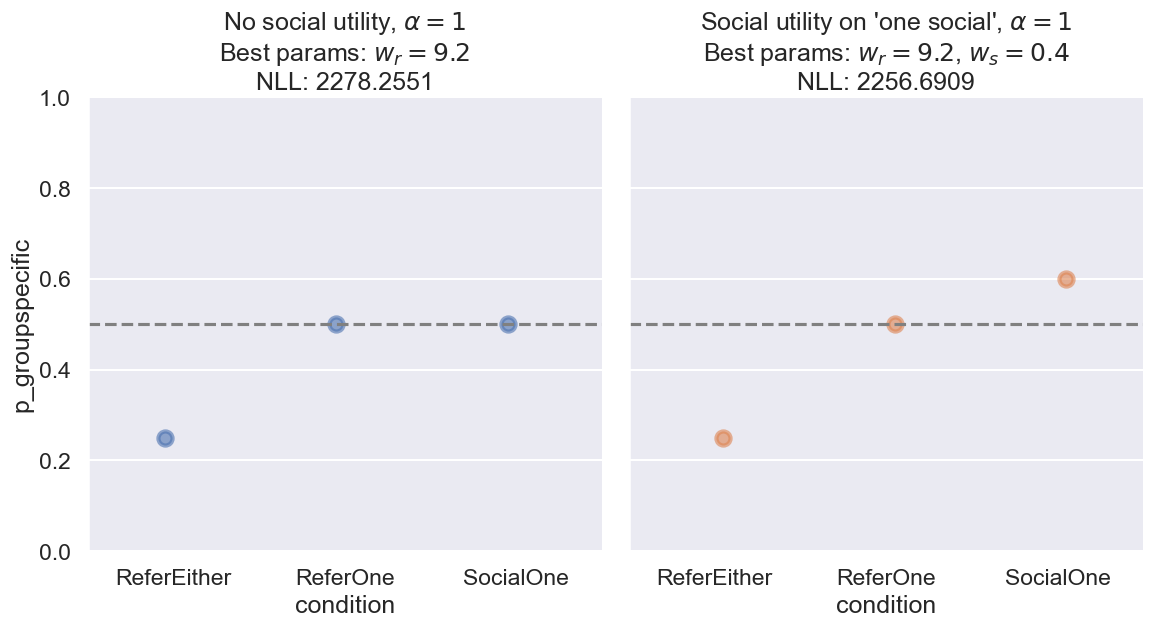

In [10]:
g = sns.catplot(
    data=df_preds,
    x="condition",
    y="p_groupspecific",
    col="type",
    kind="point",
    height=6,
    aspect=1,
    hue="type",
    dodge=0.1,
    alpha=0.6,
    linestyle="none",
    legend=False
)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")

# add an extra title to each of the plots
titles = [
    f"No social utility, $\\alpha=1$\nBest params: $w_r={best_params_no_social[1]:.1f}$\nNLL: {best_nll_no_social:.4f}",
    f"Social utility on 'one social', $\\alpha=1$\nBest params: $w_r={best_params_social[1]:.1f}$, $w_s={best_params_social[2]:.1f}$\nNLL: {best_nll_social:.4f}",
]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)  # add padding to the title

plt.show()

Do likelihood ratio test

In [11]:
# Test statistic
lr_stat = 2 * (best_nll_no_social - best_nll_social)

# Degrees of freedom: number of additional parameters in the "social" model
df = 1  # w_s is the additional parameter

p_value = chi2.sf(lr_stat, df)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_value}")

Likelihood Ratio Test Statistic: 43.12841796875
Degrees of Freedom: 1
P-value: 5.126224860460063e-11


## Fit separate params for each participant

In [12]:
best_params_social_pp, best_nll_social_pp, _ = model_tools.fit_params_participant(data_organized, tangram_info, params_list=params_list_social, expt_type=ExptTypes.SharedUnique)

In [13]:
# make best_params_social_pp into a dataframe
df_params = pd.DataFrame(columns=["alpha", "w_r", "w_s", "w_c"])
rows = []
for i, params in enumerate(best_params_social_pp):
    rows.append(
        {
            "alpha": params[0].item(),
            "w_r": params[1].item(),
            "w_s": params[2].item(),
            "w_c": params[3].item(),
        }
    )
df_params = pd.concat([df_params, pd.DataFrame(rows)], ignore_index=True)

/var/folders/fc/814yph2s11jgjvdqqz2x9w0c0000gn/T/ipykernel_77403/392003415.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_params = pd.concat([df_params, pd.DataFrame(rows)], ignore_index=True)


In [14]:
df_params

,alpha,w_r,w_s,w_c
0,1.0,16.300001,0.000000,0.0
1,1.0,14.000000,2.100000,0.0
2,1.0,14.000000,0.000000,0.0
3,1.0,0.000000,0.500000,0.0
4,1.0,2.800000,0.000000,0.0
...,...,...,...,...
60,1.0,14.400001,2.800000,0.0
61,1.0,16.000000,9.900001,0.0
62,1.0,1.000000,0.500000,0.0
63,1.0,0.000000,0.200000,0.0


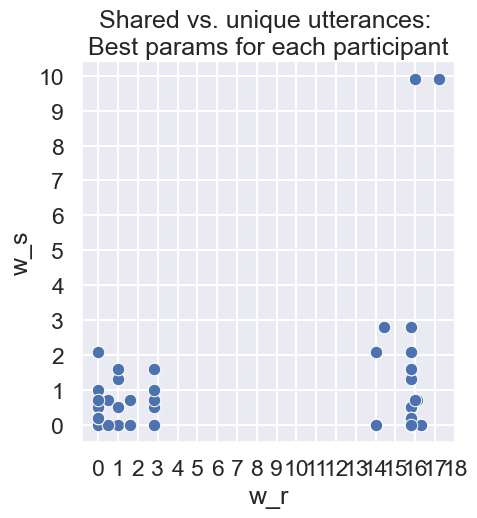

In [15]:
sns.relplot(data=df_params, x="w_r", y="w_s")
plt.xticks(range(math.ceil(df_params['w_r'].max()) + 1))
plt.yticks(range(math.ceil(df_params['w_s'].max()) + 1))
plt.title(f"Shared vs. unique utterances: \nBest params for each participant")
plt.show()


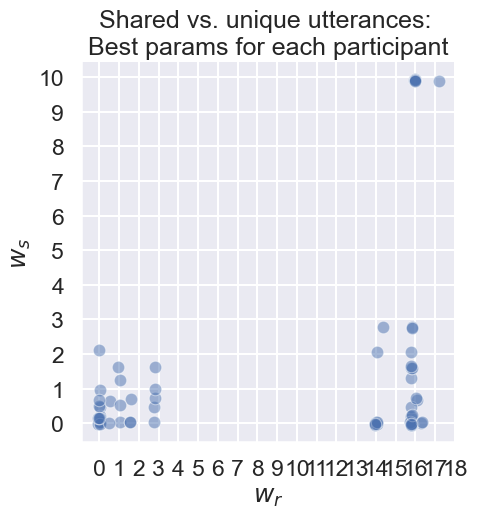

In [16]:
import numpy as np
df_jittered = df_params.copy()

np.random.seed(42)
jitter_amount = 0.05

# Create new columns with random jitter around the existing columns
df_jittered['w_r_jittered'] = df_jittered['w_r'] + np.random.uniform(
    -jitter_amount, jitter_amount, df_jittered.shape[0]
)
df_jittered['w_s_jittered'] = df_jittered['w_s'] + np.random.uniform(
    -jitter_amount, jitter_amount, df_jittered.shape[0]
)

# Now plot using the jittered columns
sns.relplot(data=df_jittered, x="w_r_jittered", y="w_s_jittered", alpha=0.5)
plt.xticks(range(math.ceil(df_params['w_r'].max()) + 1))
plt.yticks(range(math.ceil(df_params['w_s'].max()) + 1))
plt.title("Shared vs. unique utterances: \nBest params for each participant")
plt.xlabel("$w_r$")
plt.ylabel("$w_s$")
plt.show()